In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
# global variables
FOLDER_PREFIX="resnet_test_gpu_worker"

worker_num_interval = [2, 4, 8, 16, 32, 64]
# single node means, we have single worker node in cluster (ps+worker0)
single_node_time=765.886
# signle machine means we only consider training on local machine, thus there is no communication cost
single_machine_time=697.278

In [15]:
global_dict_saver = []
for num_w in worker_num_interval:
    # master is also include in this one, so the first worker should be the master
    time_stats_dict = {}
    for worker_index in range(num_w):
        if worker_index == 0:
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_master', 'rb')
        else:
            # for the case of 8 workers, we only consider master, worker0,...,worker6
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_worker_'+str(worker_index-1), 'rb')
        for line in out_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('INFO:tensorflow:Worker(.*): (.*): step (.*), loss = (.*).* examples/sec; (.*) sec/batch.*', line_string)
            if search_sth:
                worker_index, cur_step, worker_time_cost = int(search_sth.group(1)), int(search_sth.group(3)), float(search_sth.group(5))
                if cur_step <= 300:
                    #print(worker_index, cur_step, worker_time_cost)
                    if cur_step not in time_stats_dict.keys():
                        time_stats_dict[cur_step]=[worker_time_cost]
                    else:
                        time_stats_dict[cur_step].append(worker_time_cost)
    global_dict_saver.append(time_stats_dict)

pdf_saver = []
range_saver = []

for dict_idx, stat_dict in enumerate(global_dict_saver):
    counter_list = [0]*worker_num_interval[dict_idx]
    range_tmp = [i+1 for i in range(worker_num_interval[dict_idx])]
    for k, v in stat_dict.iteritems():
        sorted_v = sorted(v)
        for c_i, _ in enumerate(counter_list):
            counter_list[c_i] += sorted_v[c_i]
    counter_list = [c/float(300) for c in counter_list]
    print(counter_list)
    print(range_tmp)
    pdf_saver.append(counter_list)
    range_saver.append(range_tmp)
    print
    #print("Cluster set up with {} workers: ideal time: {} full time:{}".format(worker_num_interval[dict_idx], ideal_counter_, full_counter_))
   

[1.0903399999999999, 1.1821700000000004]
[1, 2]

[0.5407333333333333, 0.55662, 0.5932299999999999, 0.6916033333333331]
[1, 2, 3, 4]

[0.2841399999999999, 0.2863666666666665, 0.3050533333333332, 0.30804, 0.34562333333333356, 0.34671, 0.35831000000000024, 0.3885233333333342]
[1, 2, 3, 4, 5, 6, 7, 8]

[0.2205899999999998, 0.22258333333333302, 0.22965999999999961, 0.23078333333333295, 0.23116999999999965, 0.23161333333333303, 0.24072666666666614, 0.24147999999999958, 0.24219999999999967, 0.24523333333333297, 0.25004666666666625, 0.25082666666666636, 0.2565766666666663, 0.26982666666666627, 0.27561999999999964, 0.3050266666666663]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

[0.23187333333333326, 0.2553633333333332, 0.26846000000000003, 0.27610000000000007, 0.28755000000000014, 0.29663333333333325, 0.3107500000000002, 0.31623000000000007, 0.3352933333333334, 0.33976666666666666, 0.35941000000000006, 0.36138, 0.3632899999999999, 0.36545999999999995, 0.37012333333333336, 0.3714799

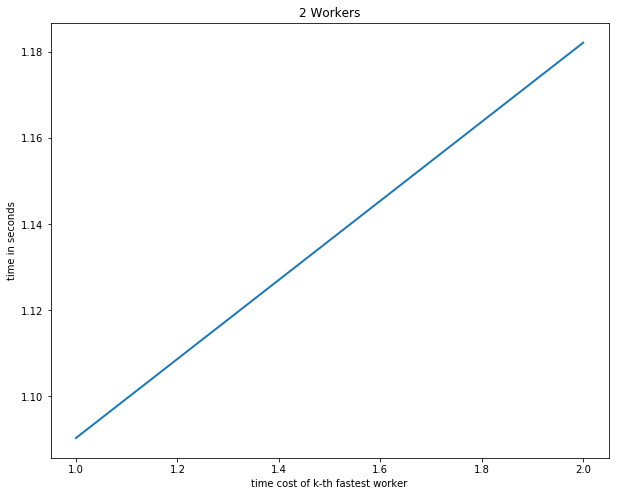

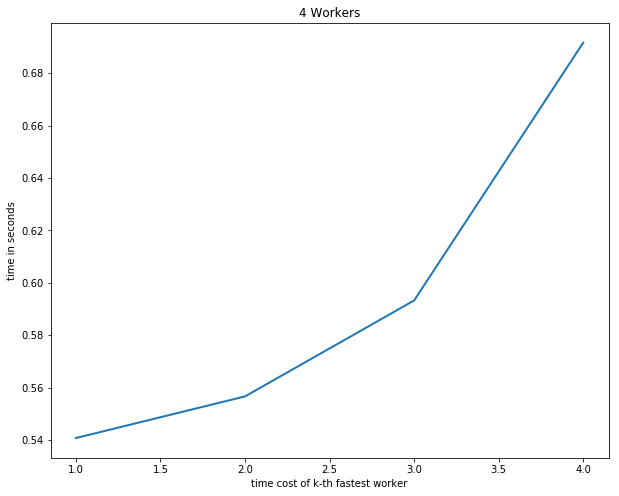

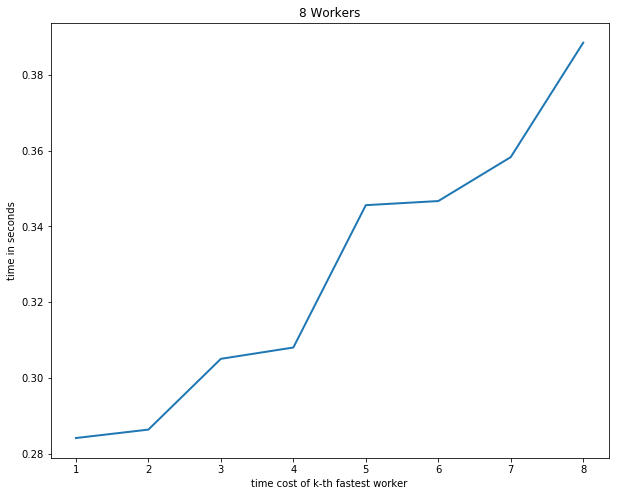

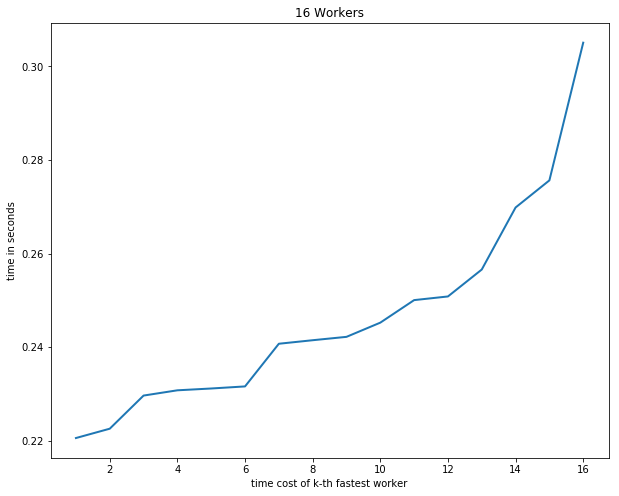

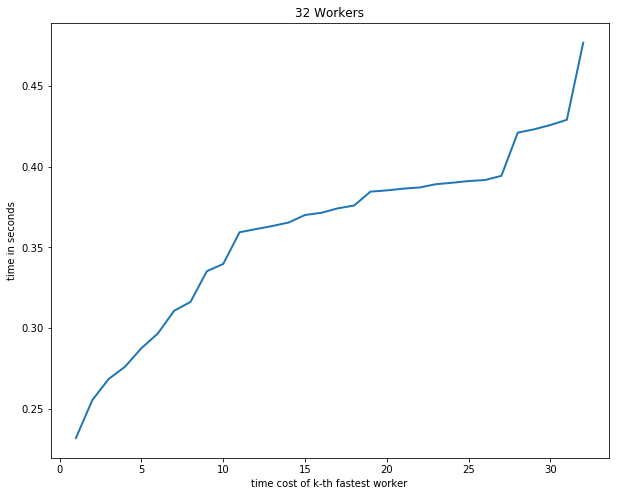

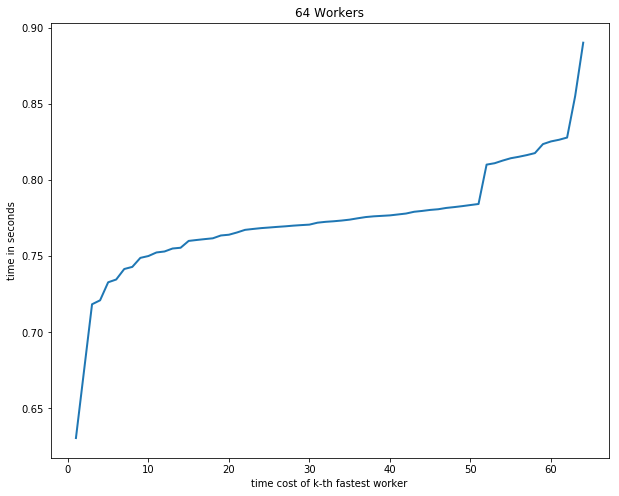

In [16]:
for i in range(len(range_saver)):
    fig = plt.figure()
    plt.plot(range_saver[i], pdf_saver[i], linewidth=2)
    plt.xlabel("time cost of k-th fastest worker")
    plt.ylabel("time in seconds")
    plt.title("{} Workers".format(worker_num_interval[i]))
plt.show()